# SISTEMA DE RECOMENDACIÓN DE VESTIDOS

Para esta parte del proyecto, crearemos un sistema de recomendación de vestidos que consistirá en buscar vestidos similares con base en la selección de un vestido en específico, todo esto a través del análisis de imágenes.

Para esto, utilizaremos una de las bases de Zalando (empresa de venta de ropa en línea en Europa). En el Clasificador de Ropa ya utilizamos la base de datos Fashion-Mnist que consiste en un conjunto de imágenes en bruto de 10 categorías de ropa. Sin embargo, en esta ocasión utilizaremos otro conjunto de datos que es "**Feidegger**" que consiste en un conjunto de datos compuesto por imágenes y descripciones exclusivamente de Vestidos.

In [ ]:
import os
import random
import requests
import numpy as np
import pandas as pd
from tqdm import tqdm
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt
from matplotlib import offsetbox

import re
import nltk
import spacy
import pickle

import tensorflow as tf
from tensorflow.keras.utils import *
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.applications import vgg16
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.imagenet_utils import preprocess_input

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

**ANÁLIZANDO LOS DATOS**

Este dataset consita de 8732 imágenes (URL de la imágen) que muestran los vestidos disponibles en la tienda Zalando y sus correspondientes descripciones.

Por ello necesitamos leer el Archivo FEIDEGGER.csv y cargarlo en un dataframe

In [ ]:
## Cargamos la base de datos de vestidos, es necesario agregar el archivo FEIDEGGER.csv
data = pd.read_csv('FEIDEGGER.csv').fillna(' ')
print(data.shape)
data.head(3)

(43944, 2)


,Image URL,Description
0,https://i2.ztat.net/large/Y0/32/1C/00/UE/11/Y0...,"kurze, sexy, sommer, sexy, party, gelb kleid, ..."
1,https://i2.ztat.net/large/Y0/32/1C/00/UE/11/Y0...,ein gelbes kleid welches eine länge bis etwa ü...
2,https://i2.ztat.net/large/Y0/32/1C/00/UE/11/Y0...,"Knielanges Stoffkleid in gelb mit weitem Rock,..."


Debido a que una Image URL (es decir un mismo vestido) puede tene más de una descripción. Agrupamos las descripciones al mismo vestido con el fin de eliminar duplicados.

In [ ]:
# Realizamos un Merge de las imagenes URL (repetidas) asignandoles las descipciones correspondientes
newdata = data.groupby('Image URL')['Description'].apply(lambda x: x.str.cat(sep=' ')).reset_index()
print(newdata.shape)
newdata.head(3)

(8792, 2)


,Image URL,Description
0,https://i1.ztat.net/large/0V/B2/1C/00/0A/11/0V...,"Ein weißes, knöchellanges Kleid. Es hat einen ..."
1,https://i1.ztat.net/large/0V/B2/1C/00/4G/11/0V...,Ein rotes faltiges Kleid mit mittellangen Ärme...
2,https://i1.ztat.net/large/1V/J2/1C/02/VH/11/1V...,"Ein Schwarzes etwa Knielanges Kleid, mit einem..."


**Red Convolucional preentrenada**

Ahora es momento de construir nuestro sistema de recomendación de vestimenta, a través de un modelo que utiliza el Knowledge Transfering (Transferencia de conocimiento). 

Para esto utilizaremos una Red Convolucional preentrendada, la VGG16 (Simonyan and Zisserman, 2015). Una estrategia para lidiar en redes neuronales profundas es usar redes previamente preentrenadas con bases de datos grandes y adaptarlas al problema de nuestro interés.

Las razones que por la que usamos VGG16 son las siguientes

* Tiene una arquitectura fácil de comprender y, en su caso, de implementar.
* Logra un excelente resultado en la competencia ImageNet (ILSVRC-2014), entre el 96% y 97%.
* Contienen relativamente pocas capas convolucionales: 13 capas convolucionales y 3 densas, de ahí que en sus nombre incluya el 16.

VGG16 fue entrenada para resolver el problema de clasificación de 1000 clases en ImageNet, debe en sus pesos codificar información para extraer rasgos de muy distintas clases  representradas en las mas de 1.4 millones de fotografías de ImageNet.

Con esta red VGG16 extraemos las características relevantes de nuestras imágenes de vestidos con el fin de identificar una similitud entre ellas.

In [ ]:
### LOAD VGG ###
vgg_model = vgg16.VGG16(weights='imagenet')
feat_extractor = Model(inputs=vgg_model.input, outputs=vgg_model.get_layer("fc2").output)
feat_extractor.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

Preparamos las imágenes para la Red Convolucional preentrenada VGG16
Vamos a cortar el VGG en la penúltima capa, de tal forma que obtengamos para cada imagen un vector de dimensión 1x4096


In [ ]:
# 1) Leemos las imágenes y expandimos su dimensión
importedImages = []

# Como vimos anteriormente, se tiene un total de 8,792 imágenes. Sin embargo, solo procesaremos 2,000 
for url in tqdm(newdata['Image URL'][0:2000]):

    response = requests.get(url) # Accedemos a la Url de las imágenes
    img = Image.open(BytesIO(response.content)) # Leemos la imagen como bytes
    img = img.resize((224, 224))
    numpy_img = img_to_array(img) # Utilizamos img_to_array de Keras que tomará una instancia de imagen y la convertirá en una matriz de numpy 
    img_batch = np.expand_dims(numpy_img, axis=0) # Expandimos la matriz de la imagen insertando un nuevo eje en la posición 0, con el fin de que posteriormente hagamos un append de las imágenes
    importedImages.append(img_batch.astype('float16'))
    
images = np.vstack(importedImages)# Apilamos la secuencia de matrices verticalmente para tener una sola matriz

processed_imgs = preprocess_input(images.copy()) # utilizamos preprocess_input como función destinada para adecuar las imágenes al formato que requiere el modelo


100%|██████████| 2000/2000 [14:34<00:00,  2.29it/s]


In [ ]:
## Extraemos las Features
# 2) Hacemos la predicción con el modelo VGG
imgs_features = feat_extractor.predict(processed_imgs)
imgs_features.shape

(2000, 4096)

In [ ]:
# Guardamos nuestro modelo en un Pickle en caso de que lo queramos cargar sin hacer todo el procesamiento

filename = 'imagesModel.pkl' # Especificamos el nombre del archivo 
outfile = open(filename,'wb') # W se refiere a que vamos a escribir en el archivo y b a que estará en el modo binario, lo que quiere decir que los datos se escribirán en forma de objetos de bytes
pickle.dump(imgs_features, outfile) # primero especificamos el archivo que queremos hacer pickle y después el archivo en donde lo vamos a guardar
outfile.close() # Cerramos el archivo

In [ ]:
## Ejecutar este paso solo en caso que carguemos el modelo desde un Pickle file previamente guardado, es decir los puntos realizados en los puntos 1 y 2
# Es necesario agregar el archivo imagesModel.pkl
with open("imagesModel.pkl", 'rb') as pickle_file:
    imgs_features = pickle.load(pickle_file)

print(imgs_features.shape)

(2000, 4096)


In [ ]:
# Dividimos nuestros datos para Entrenamiento (80%) y Pruebas (20%)
train = imgs_features[:1800]
print(train.shape)

test = imgs_features[1800:]
print(test.shape)

(1800, 4096)
(200, 4096)


# VISUALIZAMOS LOS VESTIDOS

Utilizamos una **Reducción de Componentes Principales (PCA)** y la **Incrustación de Vecinos Estocásticos Distribuidos (tSNE)** que es una técnica no lineal no supervisada utilizada principalmente para la exploración de datos y la visualización de datos de alta dimensión.

Este algoritmo nos da una intuición de como se organizan los datos en un espacio de alta dimensión.

tSNE difiere de PCA al preservar solo pequeñas distancias por pares o similitudes locales, mientras que PCA se preocupa por preservar distancias pares grandes para maximizar la varianza (datos muy diferentes terminan separados).

Es decir con tSNE los objetos similares son modelados por puntos cercanos y objetos diferentes son modelados por puntos distantes con alta probabilidad.

In [ ]:
## Reducimos la dimensión de las Features
pca = PCA(n_components=50, random_state=33) # Realizamos una reducción a los componentes principales, los cuales indicamos que será a 50
pca_score = pca.fit_transform(imgs_features)

# Aplicamos el algritmo de Incrustación de Vecinos Estocásticos Distribuidos (tSNE)
tsne = TSNE(n_components=2, random_state=33, n_iter=300, perplexity=5) # Utilizamos 2 componentes con 300 iteraciones
T = tsne.fit_transform(pca_score)

Mapeamos todas nuestras features (imagenes de vestidos TRAIN) en un espacio 2D

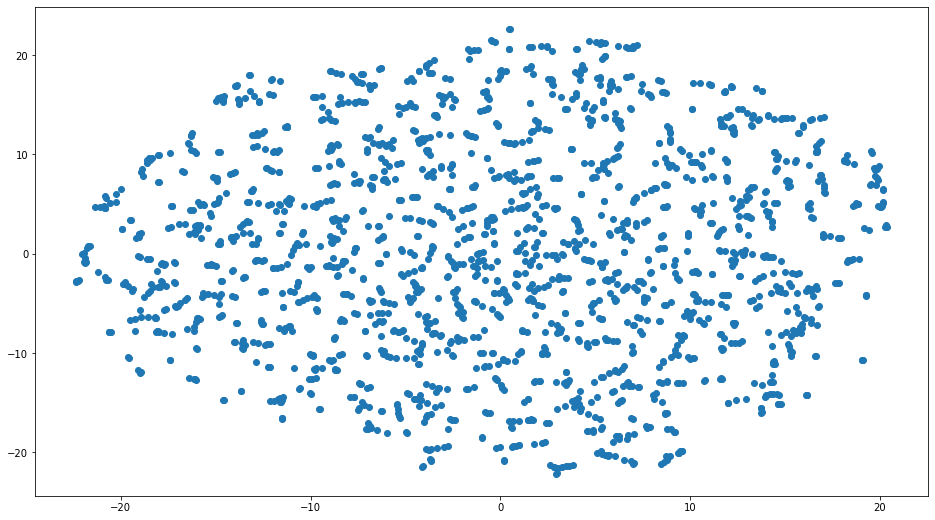

In [ ]:
fig, ax = plt.subplots(figsize=(16,9))
ax.scatter(T.T[0], T.T[1]) # Mapeamos la distribución de las imágenes (x,y) procesadas por el algoritmo tSNE
plt.grid(False)

shown_images = np.array([[1., 1.]])

Pintamos 200 imágenes de vestidos tomados de maneara aleatoria de nuestro set de daros de entrenamiento TRAIN


100%|██████████| 200/200 [00:21<00:00,  9.49it/s]


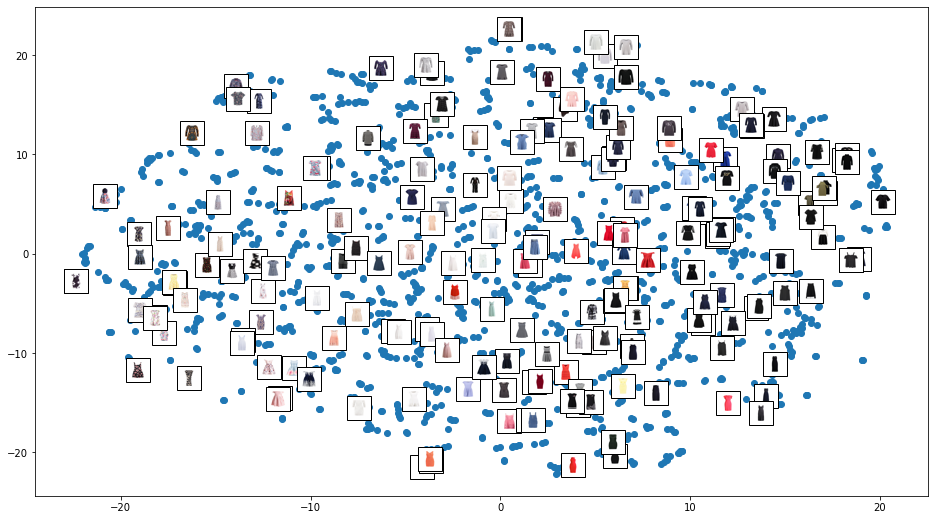

In [ ]:
fig, ax = plt.subplots(figsize=(16,9))
ax.scatter(T.T[0], T.T[1]) # Mapeamos nuevamente la distribución de las imágenes (x,y) procesadas por el algoritmo tSNE
plt.grid(False)

shown_images = np.array([[1., 1.]])

# Tomo 200 imágenes random del conjunto de 2,000 imágenes procesadas, y pintamos estos 200 vestidos
for i in tqdm(np.random.randint(1,T.shape[0],200)): # El primer argumento es el inicio, y el segundo el número límite (1800)
    
    response = requests.get(newdata['Image URL'][i]) #Buscamos la imágen correspondiente
    img = Image.open(BytesIO(response.content)) # Leemos la imagen como bytes
    img = img.resize((16, 16))
    
    shown_images = np.r_[shown_images, [T[i]]]
    imagebox = offsetbox.AnnotationBbox(offsetbox.OffsetImage(img, cmap=plt.cm.gray_r), T[i]) # Le damos formato a las imágenes y las vamos pintando
    ax.add_artist(imagebox)

plt.show()

# BUSCAMOS SIMILITUD DE VESTIDOS


Para encontrar la similitud de los vestidos utilizamos el cosine_similarity, que es una métrica que se utiliza para medir qué tan similares son dos imágenes. Matemáticamente, mide el coseno del ángulo entre dos vectores proyectados en un espacio multidimensional. La similitud de coseno es ventajosa porque incluso si las dos imagenes similares están muy separados por la distancia euclidiana (debido al tamaño del archivo), es probable que aún estén orientados más juntos. Cuanto menor sea el ángulo, mayor será la similitud del coseno. 

**ELECCIÓN:** Cada vez que se pasa una imagen de vestido, se calcula su similitud con todos los vestidos almacenados en train y luego se selecciona el más similar (con las puntuaciones de similitud más altas)

In [ ]:
## Utilizamos los datos de prueba para obtener los productos (vestidos) con mayor similitud

# Creamos una función de los productos más parecidos, en el primer parámetro se indica el id_producto y en el segundo el número de similitudes que se se busca
# Recordemos que solo especificamos 200 datos como prueba, por lo que el test_id solo puede ir de 0 a 199
def most_similar_products(test_id, n_sim = 3):
    
    plt.subplot(1, n_sim+1, 1) # Creamos un suplot con el número de similitudes+1 por el Original
    org_response = requests.get(newdata['Image URL'][train.shape[0]+test_id]) # Para obtener el dato exacto (id) de newdata, sumamos el total de datos de entrenamiento (1800)
    original = Image.open(BytesIO(org_response.content)) # Leemos la imagen como bytes
    original = original.resize((224, 224))
    plt.imshow(original) # Mostramos la imágen original
    plt.title('ORIGINAL')
    
    # Computamos la Matriz de Similtud
    cosSimilarities_serie = cosine_similarity(train, test[test_id].reshape(1,-1)).ravel() # Pasamos como parámetro los datos de entrenamiento y el original (de prueba)
    cos_similarities = pd.DataFrame({'sim':cosSimilarities_serie,'id':newdata[:train.shape[0]].index},
                                    index=newdata['Image URL'][:train.shape[0]]).sort_values('sim',ascending=False)[0:n_sim+1] # Indicamos cuantos vestidos con similitud queremos

    # Pintamos la cantidad de vestidos más similatres
    for i in range(0,n_sim):
        
        plt.subplot(1, n_sim+1, i+1+1)
        org_response = requests.get(cos_similarities.index[i])
        original = Image.open(BytesIO(org_response.content))
        original = original.resize((224, 224))
        plt.imshow(original)
        plt.title('Similar'+str(i+1)+': '+str(cos_similarities.sim[i].round(3))) # Mostramos el procentaje de similitud

Utilizamos la función *most_similar_products* y elegimos algunos vestidos de los cuáles se va a buscar su similitud. 
*   Los vestidos originales provienen de los datos de prueba "test"
*   Los vestidos de la derecha son los 5 más parecidos que hacen referencia al vestido "Original". 
*   Los vestidos "Similar" de la derecha provienen de los datos de entrenamiento "train"

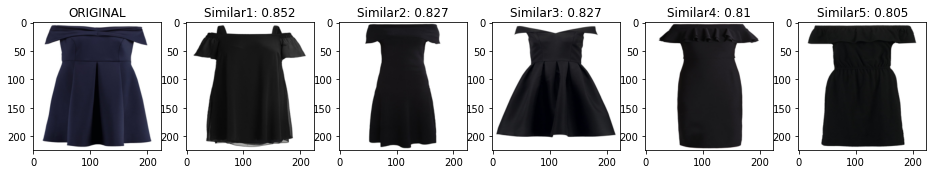

In [ ]:
plt.figure(figsize=(16,8))
most_similar_products(24,5)
plt.show()

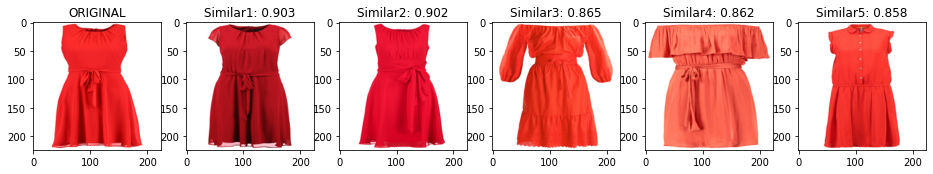

In [ ]:
plt.figure(figsize=(16,8))
most_similar_products(28,5)
plt.show()

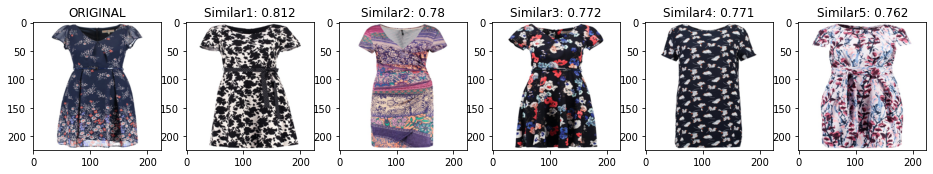

In [ ]:
plt.figure(figsize=(16,8))
most_similar_products(27,5)
plt.show()

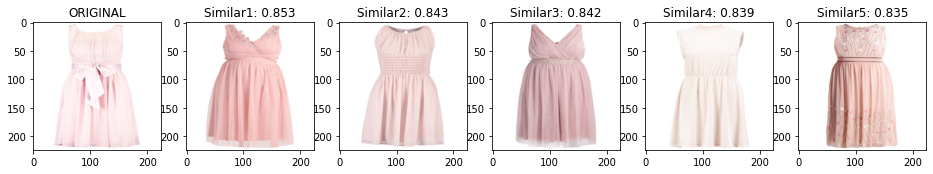

In [ ]:
plt.figure(figsize=(16,8))
most_similar_products(10,5)
plt.show()

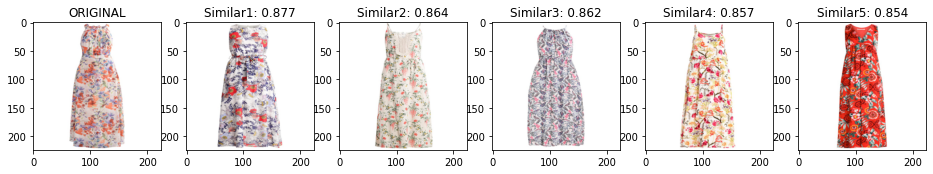

In [ ]:
plt.figure(figsize=(16,8))
most_similar_products(75,5)
plt.show()